<h1> <center>Thompson Sampling </center></h1>

<h2> Introduction </h2>

For this tutorial, we expect you have an introductory knowledge of Reinforcement learning. Thompson sampling is a process for sequential decision making where we select among the best action among a give choice of set of actions. This problem is also known as <b>multi-armed bandit problem</b>, because there are multiple arms (options) to be selected and the objective is to <b>maximize the cumulative reward if the we the play the game $T$ times</b>.

This tutorial is taken from: https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [26]:
# loading all the requisite libraries that will be required for the toy model
import scipy.stats as st
from scipy.stats import beta
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import math
import random

<h3>Exploration vs Exploitation</h3>

When selecting the arms to be pulled (or action to be taken), a user may consider past experience and future expectations. When the player starts the game:

1. she doesn't know anything about the reward from the different actions
2. as she plays the game more and more, she learns about the rewards of each action

She can never know the true distribution behind the rewards from each action as it is hidden from gamblers otherwise everyone will win and casinos will go bankrupt. In real life, we just see the immediate rewards but never know the true distribution. After learning the rewards from different actions, a user may choose to select the action with the highest reward (as learnt till now, <b>exploitation</b>) or select the next action randomly to explore and learn more about the distribution (through the new sample, <b>exploration</b>). It is also called <b>posterior sampling and probability matching</b>.

For example, if there are three arms in slot machine. A gambler plays 30 rounds (10 fir each arms), and observes that she gets a total reward of 0 in arm 1, 20 in arm 2 and 40 in arm 3. If the gambler does not exploit and believes she knows the distribution for each arm, she will always select arm 3 in all her future rounds. But what if arm 1 has a reward of a million dollar. She will never be able to get that reward as she did not explore (so missed opportunity). This difference, that is, what could she have made - what she actually made, is called <b>regret</b>.

<h3>Examples in Real Life</h3>

1. Suppose we want to check different types of donate buttons in our website. We have $K$ variants and we can wait for $T$ days. The naive approach of equally assigning the days randomly to $K$ options could be wasteful. It would be even more wasteful if running such experiments is expensive (e.g. clinical trials).

2. Building simulation models: Some simulation models are very complex and require long time to run. Running the experiments equal number of times for all the different options might be wasteful if some of the options are very poor (we can reject that option after observing just a few simulation results)

3. Google maps gives us the best route from point A to B. But as we go along the route, google monitors the time taken and expected time it will take to move to the next node. Based on this decision, google maps gives us a route suggestion (to take a different route midway). Thus, it makes decisions sequentially (and updates routes based on $K$ options).

<h2> Greedy Decisions</h2>

Greedy decisions are the easiest method for online decision making (sequential decision making). Based on history, estimate the $\theta$ or parameters for reward function, get the expected reward, select an action based on expected reward, update the history and continue. This ensures that we are <b>maximizing our immediate reward</b>.

This algorithm does not explore. This the rewards from this models depend on what rewards were observed in the first few trials. As the decision making starts after few observations only, it will go on selecting the same action forever. <b>$\epsilon$-greedy algorithm </b>selects the action (with highest reward) <b>with a probability of 1-$\epsilon$</b> and selects all the other actions with probability $\epsilon$ (with equal probability selected uniformly).

This is again wasteful if out of the $N(1-\epsilon)$ actions taken for the other options, some of the options are really poor. This problem is amplified if the experiment is expensive or the size of action set is very large. Thompson sampling allocates this intelligently.

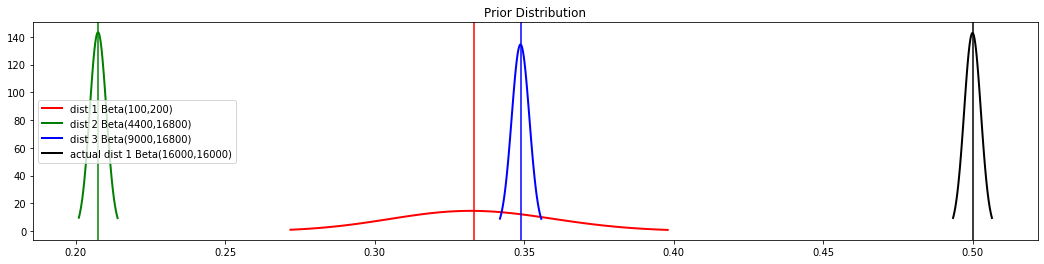

In [88]:
# Code for showing the examples of prior and posterior distribution 
# suppose these are the three options we have (K=3)
# graph below shows the mean and distribution of success for the three options
# let the actual distribution of dist 1 is given by 16000,16000 (but this is unknown)
# we also assum that the true distribution of dist 1 and dist 2 is 440/1680 and 900 and 1680

def prior():
    fig = plt.figure(figsize=(18, 4))

    A = [100,4400,9000]
    B = [200,16800,16800]
    color = ['r','g','b']
    
    for j in range(3):
        a, b = A[j], B[j]
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

        x  = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
        rv = beta(a, b)
        plt.plot(x, rv.pdf(x), 'k-', lw=2, label='dist '+str(j+1)+" Beta("+str(A[j])+","+str(B[j])+")",c=color[j])
        plt.axvline(x=A[j]/(A[j]+B[j]),c=color[j])
            
    plt.legend()
    plt.title("Prior Distribution");
    
    a, b = 16000, 16000
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

    x  = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
    rv = beta(a, b)
    plt.plot(x, rv.pdf(x), 'k-', lw=2, label="actual dist 1 Beta(16000,16000)",c='black')
    plt.axvline(x=16000/32000,c='black')
    plt.legend();
    
prior()

<h3>Code for epsilon-greedy</h3>

In [89]:
'''
Greedy algorithm will always select option distribution 3 as the expected reward is higher for dist 3
The wide (fat) tail of dist 1 shows that there is a chance that dist 1 could be better option as it has not been explored much
'''
# epsilon is the model hyper-parameter
# n is the number of trials/experiment data size conducted

# this is the true distribution (ground truth): we dont know about this
A = [16000,4400,9000]
B = [16000,16800,16800]
color = ['r','g','b']
    
@interact( epsilon = (0.05,0.7,0.05), n = (1000,2000,100))

def posterior( epsilon = 0.05, n = 1000):
    print('epsilon:',epsilon,', n:',n)
    
    # suppose we sequentially play the game (of selecting one among the 3 options)
    # in greedy we select the arm based on highest expected probability
    
    # our prior/ belief
    a = [100,4400,9000]
    b = [200,16800,16800]
    
    number_of_times_an_option_was_selected = [[0],[0],[0]]
    
    for iteration in range(n):
        expected_probability = [a[0]/b[0], a[1]/b[1], a[2]/b[2]]   # ratio of a/b gives the expectation
        select               = np.argmax(expected_probability)
        
        # considering epsilon for selection
        # if condition is satisfied, randomly select any of the other two options
        
        r = random.uniform(0,1)
        if r < epsilon:
            random_indices = [0,1,2]
            random_indices.remove(select)
            select = random.choice(random_indices)

        # draw from the posterior (where we draw from the actual distribution therefore if dist 1 is selected, 
        # we draw from there), assuming the success or failure is drawn from the ground truth
        alpha = A[select]
        beta  = B[select]
        
        draw = np.random.beta(alpha, beta, 1)[0]
        success = 0
        if draw > 0.5:
            success = 1

        # update our belief (posterior), this is based on our prior
        a[select] += success
        b[select] += 1-success
        
        for j in range(3):
            number_of_times_an_option_was_selected[j].append(0)

            if j == select:
                # updating which options was selected
                number_of_times_an_option_was_selected[select][-1] += 1
                
    for j in range(3):
        number_of_times_an_option_was_selected[j] = np.cumsum(number_of_times_an_option_was_selected[j])
        # plotting how many times each of the options were explored
        plt.plot(number_of_times_an_option_was_selected[j], label="dist "+str(j+1),c=color[j])
        print("number of times option dist "+str(j+1)+" was selected: ",number_of_times_an_option_was_selected[j][-1])
    plt.legend()

interactive(children=(FloatSlider(value=0.05, description='epsilon', max=0.7, min=0.05, step=0.05), IntSlider(…

<h3>Discussion on above graph</h3>

So what is happening in the graph above? We clearly know that the option 2 is worse than option 1 (always) as our belief is very close to the actual. This method always selects dist 3 95% of the cases and rest of the 5% are distributed equally among dist 1 and dist 2. All the money and energy spent on this approximately 2.5% on dist 2 is wasted as it is clearly bad choice as compared to dist 3, however, dist 3 could be better than dist 1 (as shown in the graph of priors)

Change the value of epsilon to see how the number of times we try the different options changes. Now, in the next method, we take a closer look into Thompson sampling to see how it works.

<h2> Thompson Sampling (TS)</h2>

We first explain it with bernoulli bandit problem to understand it better. In bernoulli bandit, there are $k$ options, and the reward is binary (success/failure). That is, the action gives a success with probability $\theta$ and failure with a probability of $1-\theta$. As shown in an example in Figure 1, greedy algorithm will always select action 1 and never select action 3. $\epsilon$-greedy algorithm with select action 1 (1-$\epsilon$) times, action 2 and action 3 $\epsilon/2$ times approximately. Thus, being wasteful $\epsilon/2$ times on action 2 (since action 2 can never improve action 1).

Thompson sampling develops and updates a posterior based on prior and observation. In the case of bernoulli, we can set weak priors (with small $\alpha$ and $\beta$ values). As we observe more and more data from different actions, update their prior. Thus posterior for only that action will be selected, that was taken. 

<b>How do we select?</b> In $\epsilon$-greedy, we update the probability (number of success/action k was taken) and select the action with the highest probability of success. In thompson sampling, we draw random samples (for probability of success) from the most recent posterior of all the actions, and select the action based on the probability of which action could perform better (based on samples of probability from posterior). It is explained through example in Figure 1 below. Finally, the posterior probability (for that action) is updated after any action is taken.

<img src="figures/bernoulliTS.jpg" width="1000">
<center>Figure 1. Example of $\epsilon$-greedy and thompson sampling</center>

Thomson sampling ensures that the probability of selecting the best option increases. Thus after a long run, we are selecting the best performing action with probability close to 1. Tis reduces our regret. Please check the paper above, they show the example as how regret in thompson sampling goes down as iterations (number of times actions are selected) increases. 

<h3>Example on notations</h3>

Using posterior analysis, thompson's sampling can be generalized to any distribution (as the example shown above for a bernoulli distribution). In Figure 2, we show mathematical notations for a generalized TS. TS is based on the capability to generate reliable posterior distribution. If the posterior distribution is not simple (or not conjugate as shown in bernoulli and beta), we can use different approximation methods e.g. MCMC and Bootstrapping (will not cover it here). 

<img src="figures/GenericTS.jpg" width="1000">
<center>Figure 2. Generalized Thompson Sampling</center>

<h3>Code on Thompson Sampling</h3>

In [91]:
# this is the true distribution (ground truth): we dont know about this
A = [16000,4400,9000]
B = [16000,16800,16800]
color = ['r','g','b']

# our prior/ belief
a = [100,4400,9000]
b = [200,16800,16800]

@interact(n = (1000,2000,100))  # start point, end point, step size

def posterior(n = 1000):
    print('n:',n)
    
    number_of_times_an_option_was_selected = [[0],[0],[0]]
    
    for iteration in range(n):
        
        # draw posterior samples and select among them as which posterior draw is the one with highest probability
        # based on the best posterior draw, select the distribution
        prob_draw = []
        for j in range(3):
            prob_draw.append(np.random.beta(a[j],b[j],1)[0])
            
        select = np.argmax(prob_draw)

        # draw from the posterior (where we draw from the actual distribution therefore if dist 1 is selected, 
        # we draw from there), assuming the success or failure is drawn from the ground truth
        alpha = A[select]
        beta  = B[select]
        
        draw = np.random.beta(alpha, beta, 1)[0]
        success = 0
        if draw > 0.5:
            success = 1

        # update our belief (posterior), this is based on our prior
        a[select] += success
        b[select] += 1-success
        
        for j in range(3):
            number_of_times_an_option_was_selected[j].append(0)

            if j == select:
                # updating which options was selected
                number_of_times_an_option_was_selected[select][-1] += 1
                
    for j in range(3):
        number_of_times_an_option_was_selected[j] = np.cumsum(number_of_times_an_option_was_selected[j])
        # plotting how many times each of the options were explored
        plt.plot(number_of_times_an_option_was_selected[j], label="dist "+str(j+1),c=color[j])
        print("number of times option dist "+str(j+1)+" was selected: ",number_of_times_an_option_was_selected[j][-1])
    plt.legend()

interactive(children=(IntSlider(value=1000, description='n', max=2000, min=1000, step=100), Output()), _dom_cl…

<h3>Discussion on Thompson Sampling</h3>

Check that in very few cases (almost 0), dist 2 will be selected (it never allocates it to dist 2 as dist 3 is always better than dist 2). However, there is a competition between dist 1 and dist 3 and dist 3 wins (as in most cases where dist 3 is selected, the draw is a success - because of its true distribution) and posterior is built using that.

Care has to be taken by considering how we chose our priors. If we use unnecessarily weak priors or non-informative prior, we might be wasting useful information we have from prior experience or domain knowledge. Stationarity is an important assumption for the approach discussed above. It assumes that the parameters do not change over time. If the parameters indeed change over time, new approach is required (one possible reason could be conditioning the rewards based on the previous reward at time t).

<h2> Recommendation System </h2>

